# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 3

In this assignment, we will go through the reward design process when you use reinforcement learning algorithms to solve a task. 

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are **160** total points to be had in this PSET, plus 10 bonus points for filling out the survey.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

In [4]:
!pip install pybullet > /dev/null 2>&1
!pip install git+https://github.com/Improbable-AI/airobot.git > /dev/null 2>&1
!pip install git+https://github.com/taochenshh/easyrl.git@sac > /dev/null 2>&1

In [5]:
# You can enable the GPU by changing the runtime (Runtime -> Change runtime type -> Hardware accelerator -> GPU )
import os
import torch
import gym
import pprint
import pybullet as p
import pybullet_data as pd
import airobot as ar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pylab
from airobot import Robot
from airobot.utils.common import quat2euler
from airobot.utils.common import euler2quat
from gym import spaces
from gym.envs.registration import registry, register
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch import nn
from pathlib import Path
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from base64 import b64encode
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
!nvidia-smi

Sat Feb 26 21:59:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   1655MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
def play_video(video_dir, video_file=None):
    if video_file is None:
        video_dir = Path(video_dir)
        video_files = list(video_dir.glob(f'**/render_video.mp4'))
        video_files.sort()
        video_file = video_files[-1]
    else:
        video_file = Path(video_file)
    compressed_file = video_file.parent.joinpath('comp.mp4')
    os.system(f"ffmpeg -i {video_file} -filter:v 'setpts=2.0*PTS' -vcodec libx264 {compressed_file.as_posix()}")
    mp4 = open(compressed_file.as_posix(),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))


# read tf log file
def read_tf_log(log_dir):
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]
    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()
    try:
        scalar_success = event_acc.Scalars('train/episode_success')
        success_rate = [x.value for x in scalar_success]
        steps = [x.step for x in scalar_success]
        scalar_return = event_acc.Scalars('train/episode_return/mean')
        returns = [x.value for x in scalar_return]
    except:
        return None
    return steps, returns, success_rate


def plot_curves(data_dict, title):
    # {label: [x, y]}
    fig, ax = plt.subplots(figsize=(4, 3))
    labels = data_dict.keys()
    for label, data in data_dict.items():
        x = data[0]
        y = data[1]
        ax.plot(x, y, label=label)
    ax.set_title(title)
    ax.legend()

def check_collision_rate(log_dir):
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/info.json'))
    log_files.sort()
    log_file = log_files[-1]
    info_data = load_from_json(log_file)
    collisions = [v['collision'] for k, v in info_data.items()]
    return np.mean(collisions)

# Environment

We will use [AIRobot](https://github.com/Improbable-AI/airobot/tree/master) for this assignment. The task here is to move the end-effector of a [UR robot](https://www.universal-robots.com/) from a fixed starting position (shown as the yellow ball in the figure below) to a fixed goal position (shown as the red ball in the figure below). The end-effector is constrained to move in $xy$-plane only (the horizontal plane). 

**State**: the 2D position of the end-effector tip, $(x, y)$ 

**Action**: 2D continuous action space, $[\Delta x, \Delta y]$. The end-effector can move in $x$ direction by $\Delta x$, $y$ direction by $\Delta y$. We scale $\Delta x, \Delta y$ so that they are in the range of $[-1, 1]$.


The following figures visually show the robot environment:

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/1_3.png" height="300"></iframe>

The robot environment is defined in the following class (`URRobotGym`). Your task is to design and fill in the reward functions. You don't need to change other parts of the code in this class.

In [179]:
class URRobotGym(gym.Env):
    def __init__(self,
                 action_repeat=10,
                 use_sparse_reward=False,
                 use_subgoal=False,
                 with_obstacle=True,
                 apply_collision_penalty=False,
                 # Set 'gui' to False if you are using Colab, otherwise the session will crash as Colab does not support X window
                 # You can set it to True for debugging purpose if you are running the notebook on a local machine.
                 gui=False,
                 max_episode_length=25,
                 dist_threshold=0.05):
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold
        self._use_sparse_reward = use_sparse_reward
        self._use_subgoal = use_subgoal
        self._apply_collision_penalty = apply_collision_penalty
        self._with_obstacle = with_obstacle
        print(f'================================================')
        print(f'Use sparse reward:{self._use_sparse_reward}')
        print(f'Use subgoal:{self._use_subgoal}')
        print(f'With obstacle in the scene:{self._with_obstacle}')
        print(f'Apply collision penalty:{self._apply_collision_penalty}')
        print(f'================================================')

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.26, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        # create an obstacle
        if self._with_obstacle:
            self._wall_id = self.robot.pb_client.load_geom('box', size=[0.18, 0.01, 0.1], mass=0,
                                                           base_pos=[0.5, 0.15, 1.0],
                                                           rgba=[0.5, 0.5, 0.5, 0.8])

        # create balls at subgoal locations
        if self._use_subgoal:
            self._subgoal_pos = np.array([[0.24, 0.15, 1.0], [0.76, 0.15, 1.0]])
            self._subgoal_urdf_id = []
            for pos in self._subgoal_pos:
                self._subgoal_urdf_id.append(self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                                            base_pos=pos,
                                                                            rgba=[0, 0.8, 0.8, 0.8]))
            # disable the collision checking between the robot and the subgoal balls
            for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
                for sg in self._subgoal_urdf_id:
                    self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                                sg,
                                                                i,
                                                                -1,
                                                                enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.02
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self):
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action):
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()
        done = self._t >= self._max_episode_length
        reward, info = self._get_reward(state=state, action=action, collision=float(collision))
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state, action, collision):
        dist_to_goal = np.linalg.norm(state - self._goal_pos[:2])
        success = dist_to_goal < self._dist_threshold
        if self._use_sparse_reward:
            #### TODO: Q1 design a sparse reward
            if success:
              reward = 1
            else:
              reward = 0            
        elif self._use_subgoal:
            reward = self._get_reward_with_subgoal(state)
        else:
            #### TODO: Q2 design a dense reward based on only the state and the goal position (no other information)
            reward = -1*dist_to_goal

        if self._apply_collision_penalty:
          if self._check_collision_with_wall():
            reward -= 5
            #### TODO: Q4 apply a collision penalty

        info = dict(success=success)
        return reward, info

    def _get_reward_with_subgoal(self, state):
        #### TODO: Q5 design a reward based on the state, goal and subgoal positions
        dist_to_goal = np.linalg.norm(state - self._goal_pos[:2])
        sg1, sg2 = self._subgoal_pos[0,:2], self._subgoal_pos[1,:2]
        thresh = np.linalg.norm(sg1 - self._goal_pos[:2])
        # print("dist ftom sg1 to goal: ", thresh)
        # print("initial dist to sg1: ", np.linalg.norm(state - sg1))
        # print("initial dist to goal: ",dist_to_goal)
        #reward = (5*dist_to_goal + 0.1*np.linalg.norm(state - sg1))*-1 #- 0.1*np.linalg.norm(state - sg2))*-1
        #good reward early, but unstable later
        #reward = (3*dist_to_goal + 0.1*np.linalg.norm(state - sg1)**2)*-1
        #---shitty
        #reward = (3*dist_to_goal + 0.3*np.linalg.norm(state - sg1)**2)*-1
        #---shitty
        #---shitty
        #reward = (6*dist_to_goal + 0.05*np.linalg.norm(state - sg1)**2)*-1
        #---shitty
        #---shitty
        #reward = (3*dist_to_goal + 0.01*np.linalg.norm(state - sg1)**2)*-1
        #---shitty

        #---decent, but long until first reward
        #reward = (3*dist_to_goal + 0.01*np.linalg.norm(state - sg1)**2)*-1
        #---decent, but long until first reward
        reward = (dist_to_goal + 0.01*np.linalg.norm(state - sg1)**2)*-1
        
        return reward

    def _get_obs(self):
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        state = gripper_pos
        return state

    def _check_collision_with_wall(self):
        if hasattr(self, '_wall_id'):
            return len(self.robot.pb_client.getContactPoints(self.robot.arm.robot_id, 
                                                             self._wall_id, 10, -1)) > 0
        else:
            return False

    def _apply_action(self, action):
        jnt_poses = self.robot.arm.get_jpos()
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False
        
        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()
        
        # if collision occurs, we reset the robot back to its original pose (before apply_action)
        collision = False
        if self._check_collision_with_wall():
            self.robot.arm.set_jpos(jnt_poses, ignore_physics=True)
            collision = True
        return collision


    def render(self, mode, **kwargs):
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb


module_name = __name__

env_name = 'URReacher-v1'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotGym',
)

For this assignment, we will use PPO to train the policy. The training code is already complete. You don't need to modify any code here.

In [9]:
# DO NOT MODIFY THIS
def train_ppo(use_sparse_reward=False, use_subgoal=False, with_obstacle=False, apply_collision_penalty=False, push_exp=False,
              max_steps=200000):
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 100
    cfg.alg.max_steps = max_steps
    cfg.alg.deque_size = 20
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = 'URPusher-v1' if push_exp else 'URReacher-v1'
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/'
    if push_exp:
        cfg.alg.save_dir += 'push'
    else:
        cfg.alg.save_dir += 'sparse' if use_sparse_reward else 'dense'
        cfg.alg.save_dir += f'_ob_{str(with_obstacle)}'
        cfg.alg.save_dir += f'_sg_{str(use_subgoal)}'
        cfg.alg.save_dir += f'_col_{str(apply_collision_penalty)}'
    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)
    env_kwargs=dict(use_sparse_reward=use_sparse_reward,
                    with_obstacle=with_obstacle,
                    use_subgoal=use_subgoal,
                    apply_collision_penalty=apply_collision_penalty) if not push_exp else dict()
    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed,
                       env_kwargs=env_kwargs)
    env.reset()
    ob_size = env.observation_space.shape[0]

    actor_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)
    if isinstance(env.action_space, gym.spaces.Discrete):
        act_size = env.action_space.n
        actor = CategoricalPolicy(actor_body,
                                 in_features=64,
                                 action_dim=act_size)
    elif isinstance(env.action_space, gym.spaces.Box):
        act_size = env.action_space.shape[0]
        actor = DiagGaussianPolicy(actor_body,
                                   in_features=64,
                                   action_dim=act_size,
                                   tanh_on_dist=cfg.alg.tanh_on_dist,
                                   std_cond_in=cfg.alg.std_cond_in)
    else:
        raise TypeError(f'Unknown action space type: {env.action_space}')

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()
    stat_info, raw_traj_info = engine.eval(render=False,
                                           save_eval_traj=True,
                                           eval_num=1,
                                           sleep_time=0.0)
    pprint.pprint(stat_info)
    return cfg.alg.save_dir


# Reaching Task without Obstacles

The first task we are going to solve is a reaching task without obstacles. We want to learn a policy that can move the robot's end-effector from the starting position to the goal position. And there is no obstacle in the scene.

## Sparse Reward

First, let's see if we can solve the reaching task by just using a sparse reward. The agent gets $+1$ reward if the end-effector tip is close to the goal position, $0$ reward otherwise.

$$r(s_t, a_t) = \begin{cases}1 \quad \text{if } \left\Vert s_t - s_g\right\Vert_2 < d_{thresh} \\ 0 \quad \text{otherwise}\end{cases}$$
where $s_g$ is the goal position, and $d_{thresh}$ is the distance threshold.

**Q1 [20 pts]**: Fill in the code for sparse reward (`use_sparse_reward=True`), train the policy with sparse reward for 200000 steps, and plot the return curve and the sucess rate curve. Hint: you can use the utility functions: `read_tf_log` and `plot_curves`.

For experiments in this assignment, if you can run them locally, then you will see that a folder `data` is created in your current working directory. And you can run `tensorboard --logdir=data` to track the experiment progress (check `train/episode_success` and `train/episode_return/mean`). If you are using colab, the `data` folder will also be created, and you can download them during the training to check the learning curves locally.



In [ ]:
#### TODO
# call train_ppo, just set the argument flag properly
save_dir_sparse = train_ppo(use_sparse_reward=True)

[INFO][2022-02-25 17:56:22]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-02-25 17:56:22]: Creating 1 environments.
[INFO][2022-02-25 17:56:22]: Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:True
Use subgoal:False
With obstacle in the scene:False
Apply collision penalty:False


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[ERROR][2022-02-25 17:56:23]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages
[INFO][2022-02-25 17:56:24]: Exploration steps: 0
[INFO][2022-02-25 17:56:24]: Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-02-25 17:56:24]: Saving checkpoint: /content/data/sparse_ob_False_sg_False_col_False/seed_0/model/model_best.pt.


KeyboardInterrupt: ignored

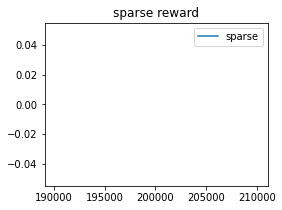

In [ ]:
#### TODO: plot return and success rate curves
steps, returns, success_rate = read_tf_log(save_dir_sparse)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "sparse reward")

In [ ]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "sparse reward")

You can visually see what the robot is doing in the testing time by running `play_video(sparse_save_dir)`. You can use this function to check the trajectories of each policy you trained.

In [ ]:
## assume the saving directory is `save_dir` (returned by `train_ppo`), then run:
# play_video(save_dir)
#### TODO: play the video (visually check what the robot ends up doing)
play_video(save_dir)

## Dense Reward

As we can see from the previous section, it is easy to specify a sparse reward. However, it makes the training much harder and the agent may fail to reach the goal. Can we provide a richer learning signal to the agent? One possibility is to provide a dense reward based on the distance between the current end-effector position and the goal position.

$$r(s_t, a_t) = -\left\Vert s_t - s_g\right\Vert_2$$


**Q2 [20 pts]**: Fill in the code for dense reward (`use_sparse_reward=False`), train the policy, and plot the return curve and the sucess rate curve.

In [180]:
#### TODO: run train_ppo
save_dir_dense = train_ppo(use_sparse_reward=False, max_steps=20000)

[INFO][2022-02-27 00:54:41]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-02-27 00:54:41]: Creating 1 environments.
[INFO][2022-02-27 00:54:41]: Load in OpenGL!


      Device:cuda
      Total number of steps:20000
Use sparse reward:False
Use subgoal:False
With obstacle in the scene:False
Apply collision penalty:False


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[ERROR][2022-02-27 00:54:43]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages
[INFO][2022-02-27 00:54:43]: Exploration steps: 0
[INFO][2022-02-27 00:54:43]: Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-02-27 00:54:43]: Saving checkpoint: /content/data/dense_ob_False_sg_False_col_False/seed_0/model/model_best.pt.


KeyboardInterrupt: ignored

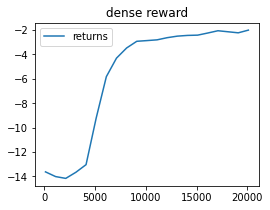

In [ ]:
#### TODO: plot curves and play the video
steps, returns, success_rate = read_tf_log(save_dir_dense)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "dense reward")

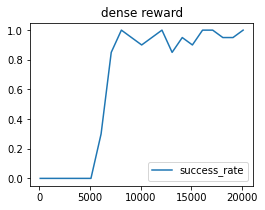

In [ ]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "dense reward")

In [ ]:
play_video(save_dir_dense)

# Reaching Task with an Obstacle

Now that you can solve the reaching task without any obstacles in the environment. Let's make the task harder. What if there is a wall(obstacle) between the starting location and the goal location. The agent will need to learn to bypass the obstacle in order to reach the goal.

Now, the environment looks like this:

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/2_3.png" height="300"></iframe>

## Simple Dense Reward

As we have seen in the previous simpler task, using a sparse reward does not work. It's safe to say that using the sparse reward will not lead to success in this harder task either. So let's jump right into the dense reward case. Let's use the distance reward that is used in the previous section and try it on this task.

**Q3 [20 pts]**: Fill in the code for dense reward when there is an obstacle (`use_sparse_reward=False, with_obstacle=True`), train the policy, and plot the return curve and the sucess rate curve.

In [48]:
#### TODO: run train_ppo
save_dir_dense_obstacle = train_ppo(use_sparse_reward=False, with_obstacle=True)

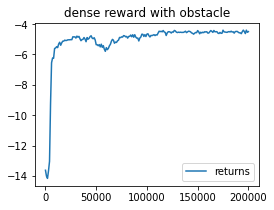

In [ ]:
#### TODO: plot curves, play the video
steps, returns, success_rate = read_tf_log(save_dir_dense_obstacle)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "dense reward with obstacle")

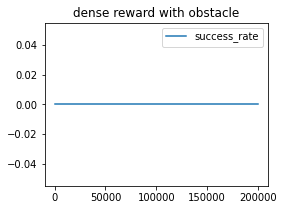

In [ ]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "dense reward with obstacle")

In [ ]:
play_video(save_dir_dense_obstacle)

## Avoid the obstacle

As we can see that using a dense reward based on the distance between the current end-effector position and the goal position does not solve the task sucessfully. What's even worse is that the end-effector is hitting the wall repeatedly. This can cause safety issues on a real robot. Idealy, we don't want the robot to hit the obstacles.

**Q4 [30 pts]**

**Q4.1 [5 pts]**: Let's first check the collision rate ($\frac{\text{# of steps in collision}}{\text{total # of episode steps}}$) of the policy learned in the previous case. We have saved the testing results in `data/`, all we need to do is just read out the collision information from the saved data. We have provided you with the utility function `check_collision_rate`. What's the collsion rate for the policy you trained with the simple dense reward? 

In [ ]:
#### TODO: get the collision rate
check_collision_rate(save_dir_dense_obstacle)

0.84

Now we want to train the robot to avoid the obstacle. A simple way to achieve this is to give the agent some penalty when it collides with the obstacle. 

**Q4.2 [20 pts]**: Apply the collision penalty when computing the reward value. Let's give $-5$ as the additional penalty whenever the agent hits the obstacle. Train the policy, and plot the return curve and the sucess rate curve. 

In [ ]:
#### TODO: run train_ppo
save_dir_collision = train_ppo(use_sparse_reward=False, with_obstacle=True, apply_collision_penalty=True, max_steps=200000//4)

[INFO][2022-02-25 21:33:52]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-02-25 21:33:52]: Creating 1 environments.
[INFO][2022-02-25 21:33:52]: Load in OpenGL!


      Device:cuda
      Total number of steps:50000
Use sparse reward:False
Use subgoal:False
With obstacle in the scene:True
Apply collision penalty:True


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[ERROR][2022-02-25 21:33:53]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages
[INFO][2022-02-25 21:33:54]: Exploration steps: 0
[INFO][2022-02-25 21:33:54]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-02-25 21:33:54]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/model_best.pt.
[INFO][2022-02-25 21:34:29]: Exploration steps: 10000
[INFO][2022-02-25 21:34:29]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000010000.pt.
[INFO][2022-02-25 21:35:05]: Exploration steps: 20000
[INFO][2022-02-25 21:35:05]: Saving checkpoint: /content/data/dense_ob_True_sg_False_col_True/seed_0/model/ckpt_000000020000.pt.
[INFO][2022-02-25 21:35:05]: Saving checkpoint: /

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -4.9653544,
 'eval/return/mean': -4.9653544,
 'eval/return/median': -4.9653544,
 'eval/return/min': -4.9653544,
 'eval/smooth_return/mean': -6.815311184030533,
 'eval/success': 0.0}


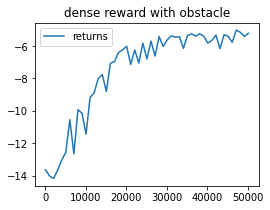

In [ ]:
#### TODO: plot curves and play the video
steps, returns, success_rate = read_tf_log(save_dir_collision)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "dense reward with obstacle")

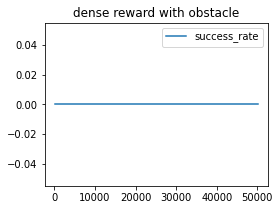

In [ ]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "dense reward with obstacle")

In [ ]:
play_video(save_dir_collision)

**Q4.3 [5 pts]** What's the collision rate now?

In [ ]:
#### TODO: get the collision rate
check_collision_rate(save_dir_collision)

0.0

## Dense reward with subgoals

As we can see in the previous section, if we add a collision penalty to the reward function, the agent can learn not to collide with the obstacle. However, it is still unable to reach the goal position as it gets stuck on the left side of the wall and never gets a chance to bypass it. We would need to design a better reward function.

Let's assume that we know two subgoal locations in the scene (shown as the light blue ball in the figures below). They are on the two sides of the obstacle. Can we use these two subgoal locations to design a better reward function such that the robot can finally reach the goal location?

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_1.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_2.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_3.png" height="300"></iframe>
<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/3_4.png" height="300"></iframe>

**Q5 [30 pts]**: Can you come up with a reward function with the subgoal information (`use_subgoal=True`) and make the robot reach the goal location? Write down the reward function $r(s_t, a_t)$ mathmatically. Same as before, train the policy and plot the return curve and the sucess rate curve. What's the collision rate in this case?

**A**:
Let $s_g$ be the goal location and let $s_{i1}, s_{i2}$ be the two subgoal locations.

$$r(s_t, a_t)= 0.5*???$$

In [ ]:
#### TODO: run train_ppo
save_dir_sg = train_ppo(use_sparse_reward=False, with_obstacle=True, 
                        apply_collision_penalty=True, use_subgoal=True, max_steps=200000)

[INFO][2022-02-27 00:54:57]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-02-27 00:54:57]: Creating 1 environments.
[INFO][2022-02-27 00:54:57]: Load in OpenGL!


      Device:cuda
      Total number of steps:200000
Use sparse reward:False
Use subgoal:True
With obstacle in the scene:True
Apply collision penalty:True


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[ERROR][2022-02-27 00:54:59]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages
[INFO][2022-02-27 00:54:59]: Exploration steps: 0
[INFO][2022-02-27 00:54:59]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-02-27 00:54:59]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/model_best.pt.
[INFO][2022-02-27 00:55:35]: Exploration steps: 10000
[INFO][2022-02-27 00:55:35]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/ckpt_000000010000.pt.
[INFO][2022-02-27 00:55:35]: Saving checkpoint: /content/data/dense_ob_True_sg_True_col_True/seed_0/model/model_best.pt.
[INFO][2022-02-27 00:56:11]: Exploration steps: 20000
[INFO][2022-02-27 00:56:11]: Saving checkpoint: /content/dat

In [1]:
#### TODO: plot curves and play the video
steps, returns, success_rate = read_tf_log(save_dir_sg)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "dense reward with subgoals")

NameError: ignored

In [ ]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "dense reward with obstacle")

In [ ]:
play_video(save_dir_sg)

In [ ]:
#### TODO: get the collision rate
check_collision_rate(save_dir_sg)

# Pushing Task

Now that you can solve the reaching task, let's try another harder task. We would like our robot to push a box (the pink object shown in the figure below) on the table from its initial position to a goal position (the red ball in the figure).

**State**: $[x_e, y_e, x_o, y_o]$, where $[x_e, y_e]$ is the 2D position of the end-effector tip, $[x_o, y_o]$ is the 2D position of the box.

**Action**: same as before.

<img src="https://raw.githubusercontent.com/dxyang/csl_imgs/master/hw3/4_1.png"  height="300"></iframe>

In [107]:
class URRobotPusherGym(gym.Env):
    def __init__(self,
                 action_repeat=10,
                 gui=False,
                 max_episode_length=25,
                 dist_threshold=0.05):
        self._action_repeat = action_repeat
        self._max_episode_length = max_episode_length
        self._dist_threshold = dist_threshold

        self._xy_bounds = np.array([[0.23, 0.78],  # [xmin, xmax]
                                    [-0.35, 0.3]])  # [ymin, ymax]
        self.robot = Robot('ur5e_stick',
                           pb_cfg={'gui': gui,
                                   'realtime': False,
                                   'opengl_render': torch.cuda.is_available()})
        self._arm_reset_pos = np.array([-0.38337763,
                                        -2.02650575,
                                        -2.01989619,
                                        -0.64477803,
                                        1.571439041,
                                        -0.38331266])
        self._table_id = self.robot.pb_client.load_urdf('table/table.urdf',
                                                        [.5, 0, 0.4],
                                                        euler2quat([0, 0, np.pi / 2]),
                                                        scaling=0.9)

        # create a ball at the start location (for visualization purpose)
        self._start_pos = np.array([0.45, -0.32, 1.0])
        self._start_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                             base_pos=self._start_pos,
                                                             rgba=[1, 1, 0, 0.8])

        # create a ball at the goal location
        self._goal_pos = np.array([0.5, 0.2, 1.0])
        self._goal_urdf_id = self.robot.pb_client.load_geom('sphere', size=0.04, mass=0,
                                                            base_pos=self._goal_pos,
                                                            rgba=[1, 0, 0, 0.8])

        # disable the collision checking between the robot and the ball at the goal location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._goal_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)
        # disable the collision checking between the robot and the ball at the start location
        for i in range(self.robot.pb_client.getNumJoints(self.robot.arm.robot_id)):
            self.robot.pb_client.setCollisionFilterPair(self.robot.arm.robot_id,
                                                        self._start_urdf_id,
                                                        i,
                                                        -1,
                                                        enableCollision=0)

        self._box_pos = np.array([0.35, -0.1, 0.996])
        self._box_id = self.robot.pb_client.load_geom('cylinder', size=[0.05, 0.05], mass=1.,
                                                      base_pos=self._box_pos,
                                                      rgba=[1., 0.6, 0.6, 1])

        self.robot.pb_client.changeDynamics(self._box_id, -1, lateralFriction=0.9)

        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._start_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)
        self.robot.pb_client.setCollisionFilterPair(self._box_id,
                                                    self._goal_urdf_id,
                                                    -1,
                                                    -1,
                                                    enableCollision=0)

        self._action_bound = 1.0
        self._ee_pos_scale = 0.02
        self._action_high = np.array([self._action_bound] * 2)
        self.action_space = spaces.Box(low=-self._action_high,
                                       high=self._action_high,
                                       dtype=np.float32)
        state_low = np.full(len(self._get_obs()), -float('inf'))
        state_high = np.full(len(self._get_obs()), float('inf'))
        self.observation_space = spaces.Box(state_low,
                                            state_high,
                                            dtype=np.float32)
        self.reset()

    def reset(self):
        self.robot.arm.set_jpos(self._arm_reset_pos, ignore_physics=True)
        self.robot.pb_client.reset_body(self._box_id, base_pos=self._box_pos)
        self._t = 0
        self._ref_ee_pos = self.robot.arm.get_ee_pose()[0]
        self._ref_ee_ori = self.robot.arm.get_ee_pose()[1]
        return self._get_obs()

    def step(self, action):
        previous_state = self._get_obs()
        collision = self._apply_action(action)
        self._t += 1
        state = self._get_obs()
        done = self._t >= self._max_episode_length
        reward, info = self._get_reward(state=state, action=action, previous_state=previous_state)
        info['collision'] = collision
        return state, reward, done, info

    def _get_reward(self, state, action, previous_state):
        object_pos = state[2:4]
        effector_pos = state[:2]
        object_pos_prev = previous_state[2:4]
        effector_pos_prev = previous_state[:2]

        dist_to_goal = np.linalg.norm(object_pos - self._goal_pos[:2])
        dist_to_obj = np.linalg.norm(object_pos - effector_pos)
        success = dist_to_goal < self._dist_threshold
        #### TODO: design the reward given state, action, and previous state
        dist_to_goal_prev = np.linalg.norm(object_pos_prev - self._goal_pos[:2])

        #--------alright results over 250k steps
        # reward = (dist_to_obj + dist_to_goal)*-1
        # delta = dist_to_goal - dist_to_goal_prev
        # reward -= delta

        # delta_eff = np.linalg.norm(effector_pos-effector_pos_prev)
        # reward += delta_eff
        #--------alright results over 250k steps

        #--------shitty
        # reward = (dist_to_obj + dist_to_goal)*-1
        # delta = dist_to_goal - dist_to_goal_prev
        # reward -= 2*delta

        # delta_eff = np.linalg.norm(effector_pos-effector_pos_prev)
        # reward += 2*delta_eff
        #--------shitty

        reward = (dist_to_obj + dist_to_goal)*-1
        delta = dist_to_goal - dist_to_goal_prev
        reward -= 0.5*delta

        delta_eff = np.linalg.norm(effector_pos-effector_pos_prev)
        reward += 0.5*delta_eff
        info = dict(success=success)
        return reward, info

    def _get_obs(self):
        gripper_pos = self.robot.arm.get_ee_pose()[0][:2]
        object_pos, object_quat = self.robot.pb_client.get_body_state(self._box_id)[:2]
        state = np.concatenate([gripper_pos, object_pos[:2]])
        return state

    def _apply_action(self, action):
        if not isinstance(action, np.ndarray):
            action = np.array(action).flatten()
        if action.size != 2:
            raise ValueError('Action should be [d_x, d_y].')
        # we set dz=0
        action = np.append(action, 0)
        pos, quat, rot_mat, euler = self.robot.arm.get_ee_pose()
        pos += action[:3] * self._ee_pos_scale
        pos[2] = self._ref_ee_pos[2]
        # if the new position is out of the bounds, then we don't apply the action
        if not np.logical_and(np.all(pos[:2] >= self._xy_bounds[:, 0]),
                              np.all(pos[:2] <= self._xy_bounds[:, 1])):
            return False

        # move the end-effector to the new position
        jnt_pos = self.robot.arm.compute_ik(pos, ori=self._ref_ee_ori)
        for step in range(self._action_repeat):
            self.robot.arm.set_jpos(jnt_pos)
            self.robot.pb_client.stepSimulation()

        return False

    def render(self, mode, **kwargs):
        robot_base = self.robot.arm.robot_base_pos
        self.robot.cam.setup_camera(focus_pt=robot_base,
                                    dist=2,
                                    yaw=85,
                                    pitch=-20,
                                    roll=0)
        rgb, _ = self.robot.cam.get_images(get_rgb=True,
                                           get_depth=False)
        return rgb




module_name = __name__

env_name = 'URPusher-v1'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{module_name}:URRobotPusherGym',
)

**Q6 [40 pts]**: Can you design a reward function so that the robot can push the box to the goal position? Write down the reward function $r(s_t, a_t)$ mathmatically. Same as before, train the policy and plot the return curve and the sucess rate curve. If the reward function is good, you will see that the success rate will be at least above $0.8$ and the curve does not collapse to $0$ (or close to $0$) as the training proceeds. **HINTS**: If you use the negative of the distance between the object and the goal location as the reward function, does it work? What if you add another term to encourage the gripper to be close to the object? If the policy still does not learn, what other reward shaping terms are helpful for the training? The information you can use include the state before and after the robot executes the action, the action that the robot takes, the radius of the object is 0.05m, the radius of the end-effector stick is about $0.02\sim0.03$m.

**A**:
$$r(s_t, a_t)=???$$

In [108]:
#### TODO: run train_ppo
# you can reduce the number of steps for debugging purpose
# but for the submission, you should run the experiment for at least 350000 steps (**max_steps=350000**)!
push_dir = train_ppo(use_sparse_reward=False, with_obstacle=True, push_exp=True,
                        apply_collision_penalty=True, use_subgoal=True, max_steps=350000)

[INFO][2022-02-26 21:28:26]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-02-26 21:28:26]: Creating 1 environments.
[INFO][2022-02-26 21:28:26]: Load in OpenGL!


      Device:cuda
      Total number of steps:350000


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
[ERROR][2022-02-26 21:28:27]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages
[INFO][2022-02-26 21:28:27]: Exploration steps: 0
[INFO][2022-02-26 21:28:27]: Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-02-26 21:28:27]: Saving checkpoint: /content/data/push/seed_0/model/model_best.pt.
[INFO][2022-02-26 21:29:08]: Exploration steps: 10000
[INFO][2022-02-26 21:29:08]: Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000010000.pt.
[INFO][2022-02-26 21:29:08]: Saving checkpoint: /content/data/push/seed_0/model/model_best.pt.
[INFO][2022-02-26 21:29:49]: Exploration steps: 20000
[INFO][2022-02-26 21:29:49]: Saving checkpoint: /content/data/push/seed_0/model/ckpt_000000020000.pt.
[INFO][2022-02-26 21:29:49]: Saving checkpoint: /content/data/

{'eval/episode_length/max': 25,
 'eval/episode_length/mean': 25.0,
 'eval/episode_length/median': 25.0,
 'eval/episode_length/min': 25,
 'eval/return/max': -3.2854326,
 'eval/return/mean': -3.2854326,
 'eval/return/median': -3.2854326,
 'eval/return/min': -3.2854326,
 'eval/smooth_return/mean': -3.606932735943616,
 'eval/success': 1.0}


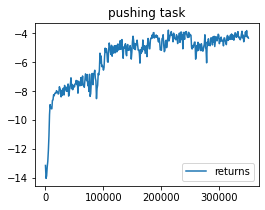

In [109]:
#### TODO: plot the curves and play the video
steps, returns, success_rate = read_tf_log(push_dir)
data_dict = {'returns': [steps,returns]}
plot_curves(data_dict, "pushing task")

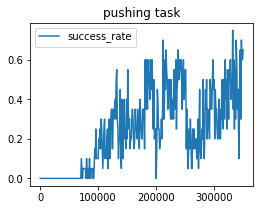

In [110]:
data_dict = {'success_rate': [steps,success_rate]}
plot_curves(data_dict, "pushing task")

In [111]:
play_video(push_dir)

# Feedback Survey (optional)

Please enter the bonus code you get after filling out the [anonymous assignment survey](https://docs.google.com/forms/d/e/1FAIpQLScQE0Mlg5qzPZL6p2VhWqyAmWPlx8XFXfBgMoaJAoewOy7DZA/viewform?usp=sf_link). (10 pts).

**Bonus code**: plus_ten_reward